# Implementing an SI epidemic spreading model

Modeling epidemics became very popular recently, but that is not why we will be implementing an SI epidemic spreading model. Our goal won't be to model an actual epidemic, but to see some fundamental aspects how how a dynamical model running on a network works, and what details need to be considered when implementing one.

Note that there are multiple types of models, for different usecases. Some models are used to simulate reality: in these cases, we usually want the results to be numericaly accurate. If we are designing a bridge, for example, we need to know how thick cables we need for a certain load to be supported. Other models, however, are used to understand the behaviour of systems. In these cases, numerical accuracy is usually not important. Instead, we want to ensure that we can understand the model to reason about what happens and why. Often, this need for understanding means that we should use a simple model, which contains only the most crucial elements and interactions. This focus, however, often means that numerical accuracy cannot be ensured -- we have to give up accuracy to help understandability.

In our case, to stick to the simplest possible model, we are going to implement an SI epidemic spreading -- ignoring various possible extensions or complications like other states (in the case of SIS or SIR models), or the mobility of the nodes, etc. The general outline of the model (see the lecture slides):

1. Each node is in one of two states, Susceptible or Infected
1. If a susceptible node is linked to an infected one, the probability of transaction (of getting infected) per unit time is $\lambda$.
1. We start with a small fraction of nodes in the Infected state, all other nodes start in the Susceptible state

How can we implement such a model? We will need to make decisions about aspects that are not covered by the outline above. Since these aspects are not part of the definition of the model, our choices here should not affect the behaviour of the model, so we are mostly free to pick whichever choices look more promising, or easier to implement. (Unfortunately, this is not always the case, as we will see a bit later on.)

## Storing the state of the simulation

Obviously we need to store the actual state of the dynamics. Storing the network of connections is easy, we can simply use a networkx network for that. Storing the susceptible / infected state of the nodes can be done in many different ways, which might subtly influence how we implement the rest of the dynamics. Some popular choices are:

1. Store the state in the network: use a node attribute which has the value either "S" or "I"
1. Use a dictionary that maps each node to either S or I
1. Use a set infected_nodes -- nodes that are in this set are infected (state "I"), nodes that are not are susceptible (S)

(The difference between the first two options is basically whether this mapping is stored in the network, or in a different datastructure)

## Advancing the simulation: updating the state

The calculation shown by Prof. Palla for modeling epidemics used differential equations, which fundamentially assumes that continuous functions are used for describing the model, and that time is a continuous variable. When implementing a simulation running on a computer, however, we need to discretize the model, since we will need to handle timesteps one after another. As mentioned on the lecture slides, using discrete time dynamics we will have each node infect each of its neighbors with probability $\lambda$ at each timestep.

## Initializing the initial state

As mentioned before, usually for modeling an epidemic, we will start with a small group of nodes in the infected state -- for simplicity, we might want to start with one single node.

Putting these aspects together we might end up with an prototype code like the following:

In [1]:
import networkx, random
import matplotlib.pyplot as plt
S = 'S'; I = 'I'

In [ ]:
g = networkx.gnp_random_graph(1000, 0.1) # some network to run on
Lambda = 0.01 # the infection probability
node_states = {node:S for node in g.nodes()}
node_states[random.choice(list(g.nodes()))] = I # start with one, randomly chosen node in I state

while True:
    for node in g.nodes(): # for each time-step, iterate over all nodes and try to infect neighbors:
        if node_states[node] is I:
            for neighbor in g.neighbors(node):
                if random.random() < Lambda:
                    node_states[neighbor] = I

(Note that actually running this code is not really a good idea yet.)

Some minor, but important aspects of the code above:

1. Two constants are defined for the S and I states. This is much better than using, for example 0 and 1, since it might be hard to remember which one belongs to which state, and is better than using the value directly. (For example, it means we will get a warning about an unknown variable if we happen to make a typo, as opposed to the code happily doing something silly.)

1. Lambda is used for the infection probability parameter (note that we cannot use the lower-case "lambda", since that is a python keyword).

1. A "while True:" loop is used for the timesteps, which means that the code above is an infinite loop

1. We need to ensure that we infect the neighbors with probability Lambda -- An easy way to do it is shown above: we generate a value with random.random(), which is uniformly distributed in the [0,1) interval, and compare it to Lambda. Personally, I can never remember which way the comparison goes, but a quick way to decide that is to check what should happen when Lambda is 0 or when it is 1.

This code implements all of the details discussed above (it stores the state, it updates it for each time-step, according to the rules of the dynamics, etc.), but is not actually working code. There are two aspects we need to cover before it will be usable:

1. We need to do something with the "while True" part to avoid having an infinite loop
1. We need to actually generate some output

Thinking a bit ahead, we also want to somehow check that our model works correctly, which we might do by comparing the output to something, so it would be a good idea to generate an output that is useful for such a comparison. We could generate a visualization showing the spread of the epidemic by drawing an image of the network, and, say, coloring the nodes according to their states. An easier visualization, however, is to simply calculate the number of infected nodes, and plot how that changes as a function of time.

Adding up the number of infected nodes can be done with a simple list comprehension:

In [ ]:
num_infected_nodes = len([node for node in g.nodes() if node_states[node] == I])

so we simply need to save the value of this at the end of each timestep. Note that this is an additional possible stumbling-block: we can't stick the calculation of num_infected_nodes just anywhere -- we want to do so for each timestep, after every other task for the given timestep is done (i.e. we did the state update required by the dynamics), which means at the end of the timestep. Conversely, the place of this line of code will effectively define where the timestep ends, and thus what we consider to be one timestep. If we place it somewhere else, our assumptions and intentions about how the code works might be different from what the code actually does, even if the code actually runs and generates some output.

As for the "while True" part, as a simple stop-gap, we might simply replace it with a "for" loop to run a few iterations. Bundling the code into a function, we get the following:

In [2]:
def si_infection_model(g, Lambda):
    node_states = {node:S for node in g.nodes()}
    node_states[random.choice(list(g.nodes()))] = I # start with one, randomly chosen node in I state
    
    result = []
    for timestep in range(5):
        for node in g.nodes(): # for each time-step, iterate over all nodes and try to infect neighbors:
            if node_states[node] is I:
                for neighbor in g.neighbors(node):
                    if random.random() < Lambda:
                        node_states[neighbor] = I
        num_infected_nodes = len([node for node in g.nodes() if node_states[node] == I])
        result.append(num_infected_nodes)
    
    return result

Which we can then call by passing in a network and a value for $\lambda$:

In [3]:
si_infection_model(networkx.gnp_random_graph(1000, 0.1), 0.01)

[2, 4, 8, 30, 83]

Of course, just printing out the resulting values isn't a really good way to look at them, drawing a plot should be much more informative. Before we do that, we should fix a minor issue in the beginning of the result: as we start with one infected node, the first number in the result should be 1 -- the reason it is not is that we calculate the numer of infected nodes at the end of each timestep, and at the end of the first timestep we already have a larger number of infected nodes. The fix is simple: as part of the initial condition, we should simply add a value to the "result" list, before the for loop that executes the timesteps gets started.

In addition, we should avoid "magic numbers" in the code -- the number of timesteps used is fixed in the function above, it is much nicer to turn that into a parameter of the function (which, in addition to allowing the code calling this function to use a different value, also serves as a documentation of the value by using a descriptive name for the variable).

In [4]:
def si_infection_model(g, Lambda, num_timesteps):
    node_states = {node:S for node in g.nodes()}
    node_states[random.choice(list(g.nodes()))] = I # start with one, randomly chosen node in I state
    
    result = []
    num_infected_nodes = len([node for node in g.nodes() if node_states[node] == I])
    result.append(num_infected_nodes)
    
    for timestep in range(num_timesteps):
        for node in g.nodes(): # for each time-step, iterate over all nodes and try to infect neighbors:
            if node_states[node] is I:
                for neighbor in g.neighbors(node):
                    if random.random() < Lambda:
                        node_states[neighbor] = I
        num_infected_nodes = len([node for node in g.nodes() if node_states[node] == I])
        result.append(num_infected_nodes)
    
    return result

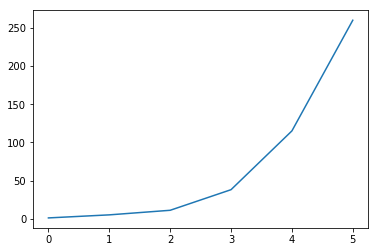

In [5]:
plt.plot(si_infection_model(networkx.gnp_random_graph(1000, 0.1), 0.01, 5))

Now that our code does something and we have a way to look at the result, we can try checking whether it appears to work correctly. Comparing the plot we get to the plots from the lecture slides, the similarity isn't really obvious. However, our plot does look similar to the beginning of those plots. Running the simulation for longer should make the result more familiar:

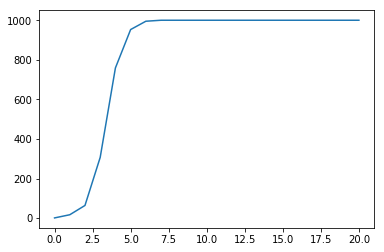

In [6]:
plt.plot(si_infection_model(networkx.gnp_random_graph(1000, 0.2), 0.01, 20))

The shape of the resulting curve now is similar to the S-shaped curve seen on the lecture slides, so at a basic level our code appears to do something sensible: the infection starts slowly, then as more and more nodes are infected it grows exponentially until it reaches a saturation. In our simple model, with on S and I states, the end state of the simulation is easy to analyize. Since the only transition changes a node from Susceptible to Infected, if we wait long enough, all nodes will get infected, as seen on the plot above. Once that state is reached, nothing will change.

Our code, however, does not know about this, and will happily simulate additional timesteps over and over. This has two drawbacks: it generates a long and unnecessary tail on the plot above, and it wastes computational resources. Fixing the plot is quite easy, we can simply trim the list returned by si_infection_model(). Being thrifty with the computation resources is a bit more challenging. We will need to replace our current logic of "generate a number of timesteps" with something more clever.

Our goal here would be to stop the simulation once the dynamic we are simulating is finished. As discussed above, once everyone is infected, nothing will change, so we can stop:

In [7]:
def si_infection_model__run_until_finished(g, Lambda):
    node_states = {node:S for node in g.nodes()}
    node_states[random.choice(list(g.nodes()))] = I
    
    result = []
    num_infected_nodes = len([node for node in g.nodes() if node_states[node] == I])
    result.append(num_infected_nodes)
    
    while num_infected_nodes < g.number_of_nodes(): # run until everyone is infected
        for node in g.nodes():
            if node_states[node] is I:
                for neighbor in g.neighbors(node):
                    if random.random() < Lambda:
                        node_states[neighbor] = I
        num_infected_nodes = len([node for node in g.nodes() if node_states[node] == I])
        result.append(num_infected_nodes)
    
    return result

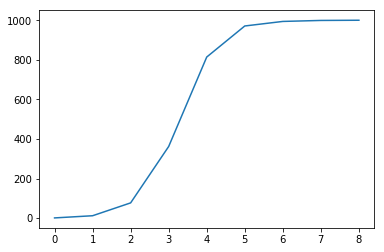

In [8]:
plt.plot(si_infection_model__run_until_finished(networkx.gnp_random_graph(1000, 0.2), 0.01))

This appears to work fine: we get a nice and efficient plot, and we even save a parameter, since we don't need to pass in the number of timesteps to simulate any more.

This is great, until someone does the following:

In [ ]:
plt.plot(si_infection_model__run_until_finished(networkx.gnp_random_graph(1000, 0.002), 0.01))

What happens when we run the code in the cell above? Nothing -- we get no result. Simply changing the network we use for the simulation, we ended up with an infinite loop.

As mentioned during a previous lab, "for" loops are unlikely to accidentially turn into infinite loops, but "while" loops are much more likely -- this is what happens here.

Note that the stopping condition we use, "stop when everyone is infected" is specific to the details of the simulation, as opposed to "run for a certain number of timesteps", which should be possible for pretty much any model. But "stop when everyone is infected" assumes that everyone will get infected. This isn't going to be true if, for example, we change to an SIR model or an SIS model. But it also won't be true if the network we are running the dynamics on is not connected. If the network is made up of several connected components, then the epidemic will spread in each one idependently of the others, and starting from one initially infected node we will infect only one component.

What can we do in this situation? An obvious fix would be to make the stopping condition more detailed. Instead of "stop when everyone is infected", use "stop when everyone in the initial node's connected component is infected". However, this is not only more complicated to write out, it is more complicated to implement and it will be even more specific. 

If we try to rethink our stopping condition to still be generalizable to other models, we might go back to "stop when the dynamic we are simulating is finished" -- how would we implement that in a general manner? If we think about how we can tell when the dynamic is finished, we might look at the plots, and stop them when they are not interesting any more. Essentially, when we get bored: if the result doesn't change, we might as well stop. Thus all we need to do is track the change in the number of infected nodes, and stop the simulation when the infection stops:

In [9]:
def si_infection_model__stop_when_no_change(g, Lambda):
    node_states = {node:S for node in g.nodes()}
    node_states[random.choice(list(g.nodes()))] = I
    
    result = []
    num_infected_nodes = len([node for node in g.nodes() if node_states[node] == I])
    result.append(num_infected_nodes)
    num_previously_infected_nodes = num_infected_nodes
    
    while True:
        for node in g.nodes():
            if node_states[node] is I:
                for neighbor in g.neighbors(node):
                    if random.random() < Lambda:
                        node_states[neighbor] = I
        num_infected_nodes = len([node for node in g.nodes() if node_states[node] == I])
        result.append(num_infected_nodes)
        if num_infected_nodes == num_previously_infected_nodes: # stop simulation if nothing changes
            break
        num_previously_infected_nodes = num_infected_nodes
    
    return result

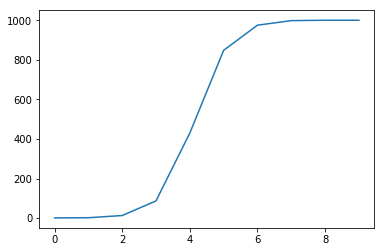

In [10]:
plt.plot(si_infection_model__stop_when_no_change(networkx.gnp_random_graph(1000, 0.2), 0.01))

At the cost of storing (and updating!) the number of infected nodes in the previous timestep, we appear to have managed to have an optimal solution: the stopping condition has nothing specific about the dynamics, and we will only run one additional timestep after reaching the final state of the simulation.

This appears to be ideal, until someone does the following:

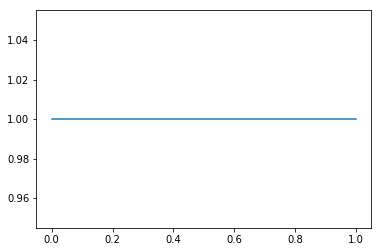

In [11]:
plt.plot(si_infection_model__stop_when_no_change(networkx.gnp_random_graph(1000, 0.2), 0.001))

Running this code with a lower $\lambda$ gives a pretty unimpressive result. What went wrong? It appears that the simulation couldn't get started. The reason: we stop the simulation when nothing changes. This condition will trigger at the end, where the S-shaped curve finishes, but it might also trigger at the beginning, since the S-shaped curve also starts with a fairly flat segment. Lowering the infection probability will mean that this start is slower, so it might happen that for the first one or two steps we don't infect anyone, which stops the simulation.

How can we fix this? One possibility is to be more tolerant -- instead of immediately stopping when nothing happened in the last timestep, allow, for example, for 5 timesteps for something to happen. This will mean that we need to use more of the history to compare to. Luckily, we don't actually have to store more state, since "result" already contains the values we need to compare to. Since we need to check whether something changed, a simple trick we can use here is to simply stuff the last few values into a set, and stop if the size of this set is 1, indicating that the last couple of values were all the same:

In [12]:
def si_infection_model__stop_when_no_change_for_long(g, Lambda, nothing_changed_tolerance):
    node_states = {node:S for node in g.nodes()}
    node_states[random.choice(list(g.nodes()))] = I
    
    result = []
    num_infected_nodes = len([node for node in g.nodes() if node_states[node] == I])
    result.append(num_infected_nodes)
    
    while True:
        for node in g.nodes():
            if node_states[node] is I:
                for neighbor in g.neighbors(node):
                    if random.random() < Lambda:
                        node_states[neighbor] = I
        num_infected_nodes = len([node for node in g.nodes() if node_states[node] == I])
        result.append(num_infected_nodes)
        
        # stop if nothing changed in the last few steps:
        if nothing_changed_tolerance < len(result) and len(set(result[-nothing_changed_tolerance:])) == 1:
            break
    
    return result

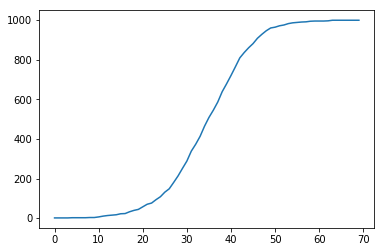

In [13]:
plt.plot(si_infection_model__stop_when_no_change_for_long(networkx.gnp_random_graph(1000, 0.2), 0.001, 7))

Note that we also need to ensure that we simulate at least the given number of steps, and also that now we have an additional parameter: the "nothing_changed_tolerance", ie. how many timesteps to wait if nothing happens. Unfortunately the addition of this additional parameter means that our code is not as general as we might have hoped: the correct value for this tolerance parameter depends on how fast our epidemic spreads. As we fiddle with $\lambda$ to simulate different scenarios, we might need to update this tolerance parameter as well. In this regard, this parameter is somewhat similar to the "num_timesteps" parameter in our first version.

As the different variations above show, formulating a good stopping condition can actually be quite difficult. In many cases, simply using a fixed number of timesteps is the easiest thing to do, even at the cost of wasting some computer time. 

There is, however an additional option, that often isn't used due to the added complexity, but it might be worth using for larger projects. What if we don't have to stop the simulation at all? If stopping at the correct time is such a problem, could we avoid the entire issue? Thinking about how we are going to use these simulations, we will pretty much always make a plot of the results. Stopping too soon is a problem since then we have partial plots, and we need to re-run those from scratch. But if we could continue the same runs, we could extend the partial plots in an efficient manner. I.e. to avoid having to stop, we would need to be able plot or somehow show the interim results. 

For example, if instead of drawing a plot we would be content with just printing out the value of num_infected_nodes, we could simply stick a print statement in the loop iterating over the timesteps, and have the user running the code stop the script when he or she has seen enough results. This would be very crude, but it would accomplish "showing the results without stopping the simulation".

Of course, to allow plotting and other analysis to be done, we would need to actually stop the function that runs the simulation. The question then becomes: could we continue the simulation? This should be possible as long as we re-initialize the state of the simulation, to ensure that we continue from exactly the same position. This would mean that we would have a "run_some_steps" function that advances the state and, in addition to the list of the number of infected nodes, it also returns the new state.

What needs to be included in this "state"? Obviously we need node_states, storing which node is in which state. We also need Lambda (and any other parameter the simulation might have) as well as the network used. Ensuring that we return these, and that the function uses these, our "run_some_steps" function might look like this:

In [14]:
def si_infection_model__initialize(g, Lambda):
    node_states = {node:S for node in g.nodes()}
    node_states[random.choice(list(g.nodes()))] = I # start with one, randomly chosen node in I state
    
    result = []
    num_infected_nodes = len([node for node in g.nodes() if node_states[node] == I])
    result.append(num_infected_nodes)
    
    return result, g, Lambda, node_states

def si_infection_model__run_some_steps(result, g, Lambda, node_states, num_timesteps):
    for timestep in range(num_timesteps):
        for node in g.nodes(): # for each time-step, iterate over all nodes and try to infect neighbors:
            if node_states[node] is I:
                for neighbor in g.neighbors(node):
                    if random.random() < Lambda:
                        node_states[neighbor] = I
        num_infected_nodes = len([node for node in g.nodes() if node_states[node] == I])
        result.append(num_infected_nodes)
    
    return result, g, Lambda, node_states

I.e. we have one function we need to call only once, and another one that will simulate a certain number of timesteps. Running them:

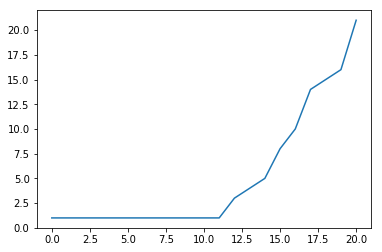

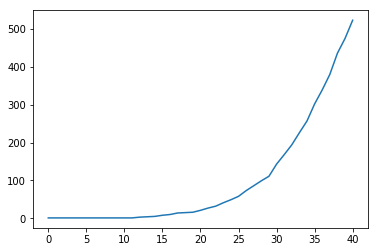

In [15]:
result, g, Lambda, node_states = si_infection_model__initialize(networkx.gnp_random_graph(1000, 0.2), 0.001)
result, g, Lambda, node_states = si_infection_model__run_some_steps(result, g, Lambda, node_states, 20)
plt.plot(result)
plt.show()
result, g, Lambda, node_states = si_infection_model__run_some_steps(result, g, Lambda, node_states, 20)
plt.plot(result)


Note that the main complication that arises with this approach is that we need to save the full state of the simulation, and to correctly re-initialize it when continuing. In the code above, this is fairly simple since we simply have to return the variables the code is already using and then use the parameters passed in, but in other cases, this might be much more complicated. Testing that we are doing this "save & restore" aspect correctly is especially tricky, since it is easy to get this subtly wrong: if we incorrectly initialize the state when continuing, the code often ends up running and producing a result, just not the result that it should.

A good method for testing this is to try simulating a bunch of timesteps twice: run, say 20 timesteps, save the state, then run 20 more timesteps. Running this second batch of 20 timesteps again should produce the same results.

Doing such a test for our code we get the following:

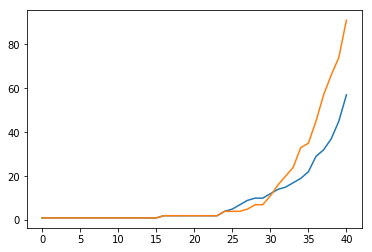

In [16]:
import copy
result, g, Lambda, node_states = si_infection_model__initialize(networkx.gnp_random_graph(1000, 0.2), 0.001)
result, g, Lambda, node_states = si_infection_model__run_some_steps(result, g, Lambda, node_states, 20)
backup_of_state = copy.deepcopy((result, g, Lambda, node_states))
# first run:
result_first_run, g, Lambda, node_states = si_infection_model__run_some_steps(result, g, Lambda, node_states, 20)

# second run, re-running the second 20 steps:
result, g, Lambda, node_states = backup_of_state
result_second_run, g, Lambda, node_states = si_infection_model__run_some_steps(result, g, Lambda, node_states, 20)

plt.plot(result_first_run)
plt.plot(result_second_run)

As the plot above shows, the two results differ after the first 20 steps, i.e. our "save & restore state" does not work fully correctly. We could argue that the difference is fairly small, that both curves appear to show the same dynamics, and only differ in random noise. However, I would suggest aiming for perfection in such situations: if we claim to be able to continue a given simulation, we should be able to continue it perfectly, and any discrepancy should be suspicious.

Tracking down the cause of this difference and fixing it is left as an optional exercise, the solution to which we will discuss next week.